# Off-Policy Methods with Approximation

The tabular off-policy methods can extend to semi-gradient methods, but they are not guaranteed to converge robustly. While this can be addressed to a limited extent, off-policy learning with function approximation is still an active research area with many open questions.

Recall that off-policy learning seeks to estimate either state or action values for either some fixed policy $\pi$ or some changing policy, but only via observing data according to some behavior policy $b$.

The challenges of off-policy learning can be divided into two components.

1. The TD-error estimate must be adjusted based on the different probabilities of taking different actions between $b$ and $\pi$.

2. Much more importantly, the distribution of states observed by the behavior policy $b$ is very different than the distribution of states observed by the target policy $\pi$.

## 11.1 Semi-Gradient Methods

It is straightforward to turn the updates of on-policy semi-gradient methods into updates for semi-gradient off-policy methods by recalling the _importance sampling_ ratio:
$$
\rho_t = \rho_{t:t} = \frac{\pi(A_t|S_t)}{b(A_t|S_t)}
$$

For TD(0), The update then becomes:

$$
\mathbf{w}_{t'+1} \quad\dot{=}\quad \mathbf{w}_t + \alpha\rho_t\delta_t\nabla\hat{v}(S_t, \mathbf{w}_{t^\prime})
$$


where $\delta_t$ is defined appropriately for either the continuing differential case or the episodic case:

For action values, the Expected Sarsa update is:

$$
\mathbf{w}_{t'+1} \quad\dot{=}\quad \mathbf{w}_t + \alpha\delta_t\nabla\hat{q}(S_t, \mathbf{w}_t')
$$

where $\delta_t$ is defined as before for Expected SARSA. Note that there is no importance sampling ratio in the Sarsa update, which is explained later.

In the multi-step case, we simply have as our importance sampling ratio:
$$
\rho_{t+1:t+n} = \prod_{k=t}^{t+N-1}{\frac{\pi(A_k|S_k)}{b(A_k|S_k)}}
$$


1. Convert the equation of $n$-step off-policy TD (7.9) to semi-gradient form. Give accompanying definitions of the return for both the episodic and continuing cases.

$$
\mathbf{w}_{t+1} = \mathbf{w}_t + \alpha \rho_t \left[ G_{t:t+n} - \hat{v}(S_t, \mathbf{w}_t)\right]\nabla\hat{v}(S_t, \mathbf{w}_t)
$$

Where, for the episodic case, we have:

$$
\begin{align}
\rho_t &= \prod_{k=t}^{\min(T, t + n) - 1}{\frac{\pi(A_k|S_k)}{b(A_k|S_k)}}\\\\
G_{t:t+n} &= \sum_{k=t+1}^{\min(T, t + n) - 1)}{\gamma^{k-t-1}R_k} + \gamma^n\hat{v}(S_{t+n}, \mathbf{w_t})\mathbb{1}[t + n < T]
\end{align}
$$

While in the continuing case we have:

$$
\begin{align}
\rho_t &= \prod_{k=t}^{t + n - 1}{\frac{\pi(A_k|S_k)}{b(A_k|S_k)}}\\\\
G_{t:t+n} &= \sum_{k=t+1}^{t + n - 1}{(R_k - \bar{R}_{k-1})} + \hat{v}(S_{t+n}, \mathbf{w_t})
\end{align}
$$

2. Convert the equations of $n$-step $Q(\sigma)$ (7.11 and 7.17) to semi-gradient form. Give definitions that cover both the episodice and continuing cases.

$$
\mathbf{w}_{t+1} = \mathbf{w}_t + \alpha \left[ G_{t:t+n} - \hat{q}(S_t, A_t, \mathbf{w}_t)\right]\nabla\hat{q}(S_t, A_t, \mathbf{w}_t))
$$

Where $G_{t:h}$ is defined in the discounted case as:

$$
\begin{align}
h &= \min(T, t + n)\\
G_{t:h} \quad&\dot{=}\quad R_{t+1} + \gamma(\sigma_{t+1}\rho_{t+1} + (1 - \sigma_{t+1})\pi(A_t|S_t))(G_{t+1:h} - \hat{q}_{h-1}(S_{t+1}, A_{t+1}, \mathbf{w}_t)) + \gamma \bar{v}_{h-1}(S_{t+1})
\end{align}
$$

And $G_{t:h}$ is defined in the continuing case as:

$$
\begin{align}
G_{t:h} \quad\dot{=}\quad R_{t+1} + (\sigma_{t+1}\rho_{t+1} + (1 - \sigma_{t+1})\pi(A_t|S_t))(G_{t+1:h} - \hat{q}_{h-1}(S_{t+1}, A_{t+1}, \mathbf{w}_t)) - \bar{R}_t + \bar{v}(S_{t+1}, \mathbf{w}) - \bar{R}_t
\end{align}
$$

Where

$$
\bar{v}(s, \mathbf{w}) = \sum_{a\in\scr{A}(s)}\pi(a|s)\hat{q}(s, a, \mathbf{w})
$$

and $\sigma_{t+1} \in (0, 1)$ is chosen by some procedure at each decision from $1$ to $h$.

## 11.2 Examples of Off-policy Divergence

3. Apply one-step semi-gradient Q-learning to Baird's counterexample and show empirically that its weights diverge.

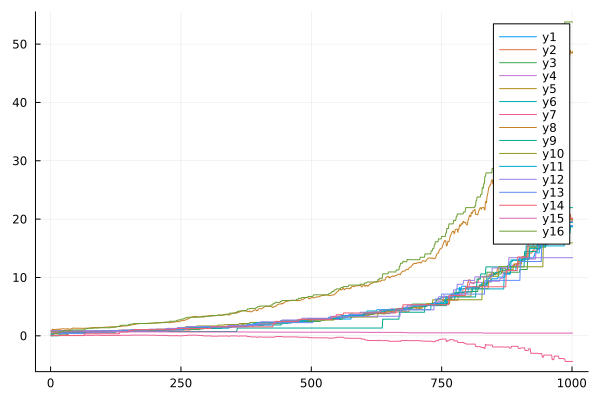

In [12]:
𝓢 = collect(1:7)
𝓐 = [:dashed, :solid]
γ = 0.99

π_(s, a) = a == :solid ? 1 : 0
π_sample(s) = :solid
b(s, a) = a == :dashed ? 6/7 : 1/7
b_sample(s) = rand(vcat(repeat([:dashed], 6), [:solid]))
p_sample(s, a) = (a == :dashed ? rand(1:6) : 7, 0)

function x(s)
    x = zeros(8)
    if s == 7
        x[7] = 1
        x[8] = 2
    else
        x[s] = 2
        x[8] = 1
    end
    return x
end

function q_learning(;ε=0.1, N=1000, α=0.1)
    W = zeros(N + 1, 2, 8)
    W[1, :, :] = rand(2, 8)
    q(s, a, w) = a == :dashed ? (w*x(s))[1] : (w*x(s))[2]
    grad_q(s, a) = a == :dashed ? [x(s) zeros(8)]' : [zeros(8) x(s)]'
    s = rand(𝓢)
    for i in 1:N
        w = W[i, :, :]
        a = b_sample(s)
        sp, r = p_sample(s, a)
        W[i+1, :, : ] = w + α*(r + γ * maximum(a -> q(sp, a, w), 𝓐)  - q(s, a, w)) * grad_q(s, a)
        s = sp
    end
    
    return W
end

W = q_learning();

using Plots

plot(W[:, 1, 1:8])
plot!(W[:, 2, 1:8])

## 11.4 Linear Value-function Geometry

We can imagine the space of possible value functions over a discrete state space as being a finite-dimensional Euclidean vector space in order to draw upon our intuition. In particular, we can consider the case of an MDP with 3 states, $\{ s_1, s_2, s_3 \}$, where the possible value functions are represented by with the three-dimensional space $\mathbf{v} \in \mathbb{R}^3$. Furthermore, if we consider the case of linear function approximation with two parameters $\mathbf{w} \in \mathbb{R}^2$, then our space of representable value functions will form a linear subspace, in this case, a plane embedded in $\mathbb{R}^3$.

If we consider a particular policy $\pi$'s value function, $v_\pi$, it will, in general, not be in the subspace spanned by $\mathbf{w}$. We can instead find the $\mathbf{v}$ that is closest to $v_\pi$ in the subspace, where "closeness" is defined by an on-policy distribution weighted norm.

$$
\|\mathbf{v}\|_\mu = \sum_s{\mu(s)\mathbf{v}(s)}
$$

Note that $\overline{\mathrm{VE}} = \|\mathbf{v} - \mathbf{v}_\pi \|_\mu$.

We define a projection operator $\Pi$ as

$$
\Pi \mathbf{v} = \arg_\mathbf{w}\min\|v - u\|_\mu.
$$


The TD methods find different solutions. Note that we can define the Bellman operator on value function space:

$$
B_\pi \mathbf{v} = \sum_{a,s',r}{p(s',r\mid s, a)\pi(a \mid s)\left(r + \gamma v(s')\right)}
$$

Note that for the policy value function $v_\pi$ is a fixed point of $B_\pi$ and that dynamic programming corresponds to iterating the Bellman operator until a fixed point is found.

$$
\mathbf{v}^* = B_\pi\dots B_\pi\mathbf{v}_{init}
$$

Note however that in DP-learning with approximation (and in some sense, in TD-learning), we apply the Bellman operator and then project into the subspace spanned by $\mathbf{w}$.

$$
\mathbf{v}^* = \Pi B_\pi \dots \Pi B_\pi \mathbf{v}_{init}
$$

Further, define the TD-error at $\mathbf{v}$ as $\overline\delta_\mathbf{v} = B_\pi \mathbf{v} - \mathbf{v}$.

Define the projected Bellman error as

$$
\overline{\mathrm{PBE}}(\mathbf{v}) = \| \Pi \overline\delta_\mathbf{v} \|_\mu
$$

The point in the space spanned by $\mathbf{w}$ with $\overline{\mathrm{PBE}}$ is $\mathbf{w}_{\mathrm{TD}}$


$s$ | $v_{TD}$ | $v_\pi$ | $\delta_{TD}$ | $\quad\delta_\pi$
---|---|---|---|---
A | $\frac{1}{2}$ | $\frac{1}{2}$ | $\frac{1}{4}$ | 
B | $\frac{3}{4}$ | $1$ | $\frac{1}{4}$ |
C | $\frac{1}{4}$ | $0$ | $\frac{1}{4}$ | 

## 11.5 Gradient Descent in the Bellman Error

## 11.6 The Bellman Error is Not Learnable

> *_Exercise 11.4_ Prove (11.24). Hint: Write the $\overline{\operatorname{RE}}$ as an expectation over possible states $s$ of the error (before squaring), grouping the subtracted value with the return and the added true value with the estimated value. Then, if you expand the square, the most complex term will end up being zero, leaving you with (11.24).

$$
\newcommand{\re}{\overline{\mathrm{RE}}}
\newcommand{\w}{\mathbf{w}}
\newcommand{\E}{\mathbb{E}}
\begin{align}
\re(\w) &= \E_s\left[\E\left[\left(G_t - \hat{v}(s)\right)^2\mid S_t = s\right]\right]\\\\
&= \E_s\left[\E\left[\left(G_t - v_\pi(s) + v_\pi(s) - \hat{v}(s)\right)^2\right]\mid S_t = s\right]\\\\
&= \E_s\left[\E\left[\left(G_t - v_\pi(s)\right)^2 + \left(v_\pi(s) - \hat{v}(s)\right)^2 + 2\left(G_t - v_\pi(s)\right)\left(v_\pi(s) - \hat{v}(s)\right) \right]\right]\\\\
&= \E_s\left[\E\left[\left(G_t - v_\pi(s)^2\right) + \left(v_\pi(s) - \hat{v}(s)\right)^2 + 2G_tv_\pi(s) - 2v_\pi(s)^2 - 2G_t\hat{v}(s) + 2v_\pi(s)\hat{v}(s) \right]\right]\\\\
&= \E\left[\left(G_t - v_\pi(s)^2\right)\right] + \E\left[\left(v_\pi(s) - \hat{v}(s)\right)^2\right] + \E\left[G_tv_\pi(s) - v_\pi(s)^2 - G_t\hat{v}(s) + v_\pi(s)\hat{v}(s)\right]\\\\
&= \E\left[\left(G_t - v_\pi(s)^2\right)\right] + \E\left[\left(v_\pi(s) - \hat{v}(s)\right)^2\right] + \E\left[G_tv_\pi(s)\right] - \E\left[v_\pi(s)^2\right] - \E\left[G_t\hat{v}(s)\right] + \E\left[v_\pi(s)\hat{v}(s)\right]\\\\
&= \E\left[\left(G_t - v_\pi(s)^2\right)\right] + \E\left[\left(v_\pi(s) - \hat{v}(s)\right)^2\right] + \E\left[v_\pi(s)^2\right] - \E\left[v_\pi(s)^2\right] - \E\left[v_\pi(s)\hat{v}(s)\right] + \E\left[v_\pi(s)\hat{v}(s)\right]\\\\
&= \E\left[\left(G_t - v_\pi(s)^2\right)\right] + \E\left[\left(v_\pi(s) - \hat{v}(s)\right)^2\right]
\end{align}
$$

## 11.7 Gradient-TD Methods

## 11.8  Emphatic TD-Methods

## 11.9 Reducing Variance

## 11.10 Summary